In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from functools import partial

First let's process the data.

In [2]:
# An array to store the rows of data.
rows = []

In [3]:
with open('glass.dat') as f:
    for line in f:
        row = line.split()
        rows.append(row)

In [4]:
# The rows containing data (not names of columns).
data_rows = rows[1:]

In [5]:
data_rows = [row[1:] for row in data_rows]

In [6]:
# Column names.
cols = rows[0]

In [7]:
df = pd.DataFrame.from_records(data_rows)

In [8]:
df.columns = cols

In [9]:
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
0,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00,WinF
1,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.00,WinF
2,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.00,WinF
3,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.00,WinF
4,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.00,WinF
...,...,...,...,...,...,...,...,...,...,...
209,-1.77,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.00,Head
210,-1.15,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.00,Head
211,2.65,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.00,Head
212,-1.49,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.00,Head


In [10]:
for col in ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']:
    df[col] = df[col].astype('float')

In [11]:
# The variable whose density we will estimate.
X = df['RI'].to_numpy()

In [12]:
X

array([ 3.01, -0.39, -1.82, -0.34, -0.58, -2.04, -0.57, -0.44,  1.18,
       -0.45, -2.29, -0.37, -2.11, -0.52, -0.37, -0.39, -0.16,  3.96,
        1.11, -0.65, -0.5 ,  1.66, -0.64, -0.49, -0.8 , -0.36, -0.07,
       -0.79, -0.32, -0.16, -0.32, -0.53, -0.25, -0.47, -0.17, -2.33,
        1.09, -0.03,  4.13,  4.13, -0.07, -0.45, -0.21,  4.1 , -0.14,
        1.  ,  0.69,  8.67,  4.23,  0.98,  5.2 ,  1.26,  0.08,  0.37,
       -0.22, -0.31, -5.85,  0.24, -0.46, -0.46,  1.05,  1.77,  3.72,
        4.27,  3.72,  2.99,  3.52,  3.52,  3.52,  5.  , -2.26,  0.48,
       -2.07, -1.69, -2.04, -2.1 , -1.55, -1.73, -1.87, -2.1 , -2.08,
       -2.07, -1.54, -2.06, -3.91, -1.75, -2.31, -1.55, -1.82, -1.6 ,
        0.41, -1.95, -2.12, -2.1 , -1.71,  0.6 ,  0.41, -0.57, -1.11,
        0.11, -1.45, -0.7 ,  0.2 ,  9.25,  6.1 ,  6.75, 13.25, 15.93,
        4.22,  0.18,  8.64,  9.39,  9.77,  0.92,  0.47,  0.46,  0.29,
       -0.92, -1.27, -1.48,  0.44, -1.37, -1.13, -0.93,  3.77,  0.72,
       -1.33,  2.81,

In [13]:
# Upper and lower bounds on the sampled values for X.
lower, upper = -20, 20

In [14]:
ran = upper - lower

In [15]:
n = len(X)

Let's compute a histogram estimator for the density of $X$. To do this we'll use Theorem 20.7 to compute the cross-validation estimator of risk, and find a value $h$ for the binwidth which is close to the minimum.

In [16]:
# Rescale the data to [0,1] to form a histogram estimator
X_hist = (X - lower) / ran

In [17]:
hist_risks = []

for n_bins in range(1,400):
    bin_width = 1 / n_bins
    
    # First we compute the values \hat p_j in equation 20.14.
    ps = []
    for i in range(n_bins):
        low = i*bin_width
        up = (i+1)*bin_width
        ps.append(((X_hist >= low) & (X_hist < up)).sum() / n)
    
    ps = np.array(ps)
    
    # The quantity \hat J(h) in equation 20.14.
    J = 2 / ((n-1) * bin_width) - ((n+1) / (bin_width * (n-1))) * (ps**2).sum()

    hist_risks.append(J)

In [18]:
hist_risks = np.array(hist_risks)

Here is a plot of the cross-validation estimators of risk.

Text(0.5, 1.0, 'Cross-validation estimator of risk versus number of bins')

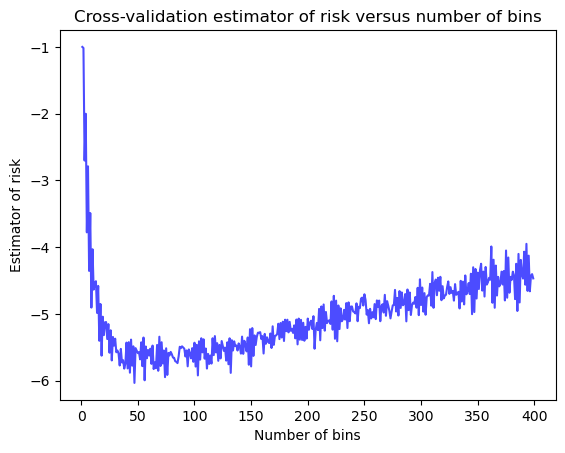

In [19]:
plt.xlabel('Number of bins')
plt.ylabel('Estimator of risk')
plt.plot(range(1,400), hist_risks, c='blue', alpha=0.7)
plt.title('Cross-validation estimator of risk versus number of bins')

In [20]:
# The number of bins that gives the lowest value of \hat J
# among the numbers of bins that we tested.
n_best_bins = np.argmin(hist_risks) + 1

In [21]:
print(f'Estimated number of bins minimizing the risk: {n_best_bins}')

Estimated number of bins minimizing the risk: 47


Let's compare histogram estimators for different numbers of bins.

In [22]:
def compute_ps(n_bins):
    """
    Compute the set of bins and values \hat p_i on each bin.
    
    n_bins: number of bins to use in histogram estimator
    """
    
    # The values \hat p_i
    ps = []
    bin_width = 1 / n_bins
    
    # The set of bins
    bins = [i*bin_width for i in range(n_bins+1)]

    for i in range(n_bins):
        low = i*bin_width
        up = (i+1)*bin_width
        ps.append(((X_hist >= low) & (X_hist < up)).sum() / n)
    
    return ps, bins

In [23]:
def hist_est(n_bins):
    """
    Return the histogram estimator function with n_bins bins.
    """
    ps, bins = compute_ps(n_bins)
    
    def f(x):
        if (x <= 0) | (x >= 1):
            return 0
        for i in range(n_bins):
            if (x >= bins[i]) & (x < bins[i+1]):
                return ps[i] * n_bins
    
    return f

Here is a plot of the histograms with different numbers of bins. The estimated optimal number of bins is 47.

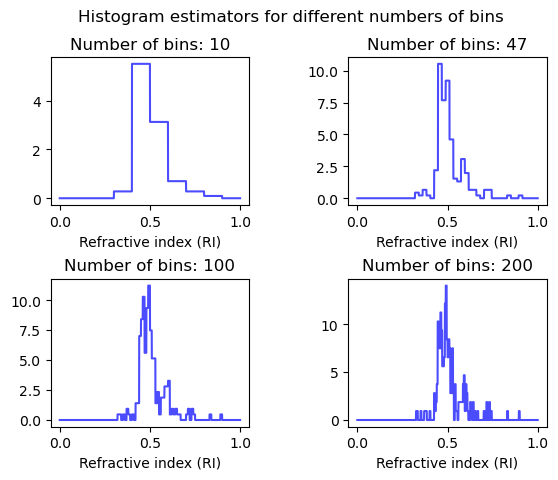

In [24]:
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Histogram estimators for different numbers of bins')

x = np.linspace(0, 1, 10000)
for i,n_bins in enumerate([10, n_best_bins, 100, 200]):
    ax = axs[i // 2][i % 2]
    f = hist_est(n_bins)
    y = list(map(f, x))
    ax.plot(x, y, c='blue', alpha=0.7)
    ax.set_xlabel('Refractive index (RI)')
    ax.set_title(f'Number of bins: {n_bins}')

Now let's compute a confidence band for the best histogram estimator using Theorem 20.10.

In [25]:
# A standard normal distribution.
dist = norm

In [26]:
# The value z appearing in equation 20.18.
z = dist.ppf(1 - (0.05 / (2 * n_best_bins)))

In [27]:
# The value c appearing in equation 20.18.
c = (z / 2) * np.sqrt(n_best_bins / n)

In [28]:
# Our estimated best histogram estimator.
f_hist = hist_est(n_best_bins)

In [29]:
def l_hist(x):
    """The lower bound function l in Theorem 20.10."""
    return max(np.sqrt(f_hist(x)) - c, 0)**2

In [30]:
def u_hist(x):
    """The upper bound function u in Theorem 20.10."""
    return (np.sqrt(f_hist(x)) + c)**2

Here is a plot of our estimated histogram.

In [31]:
x = np.linspace(0, 1, 10000)

In [32]:
l_hist_vals = list(map(l_hist, x))

In [33]:
u_hist_vals = list(map(u_hist, x))

Text(0.5, 1.0, '95% confidence band for the density function')

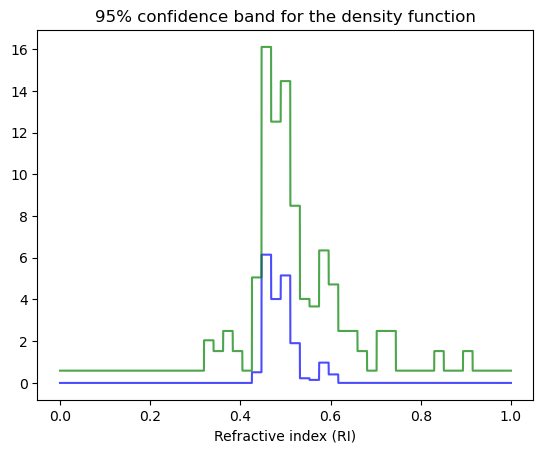

In [34]:
plt.plot(x, l_hist_vals, c='blue', alpha=0.7)
plt.plot(x, u_hist_vals, c='green', alpha=0.7)
plt.xlabel('Refractive index (RI)')
plt.title('95% confidence band for the density function')

Now let's compute a kernel density estimator.

In [35]:
# A Gaussian kernel
K = norm.pdf

In [36]:
# This is the function K^{(2)} appearing in Theorem 20.15
# The function is the same as the convolution of K with
# itself, and is a Gaussian kernel again.
K_conv = partial(norm.pdf, loc=0, scale=np.sqrt(2))

In [37]:
# The function K^* appearing in Theorem 20.15
K_star = lambda x: K_conv(x) - 2*K(x)

We'll again use the cross-validation estimator of risk to find an optimal bandwidth.

In [38]:
# The number of bandwidths to test
num_widths = 10000

In [39]:
# The set of bandwidths to test
bandwidths = np.linspace(0.00001, 1, num=num_widths)

In [40]:
# An array to store the cross-validation estimators of risk
ker_risks = []

In [41]:
# The matrix of differences of entries of X
diff_matrix = X - X.reshape(-1,1)

In [42]:
for i, h in enumerate(bandwidths):
    # The first term in equation 20.25
    array_to_sum = K_star(diff_matrix / h)
    first_term = np.sum(array_to_sum) / (h * n**2)
    
    # The second term in equation 20.25
    second_term = 2 * K(0) / (n * h)
    
    risk = first_term + second_term
    ker_risks.append(risk)

In [43]:
ker_risks = np.array(ker_risks)

Text(0.5, 1.0, 'Cross-validation estimator of risk vs bandwidth')

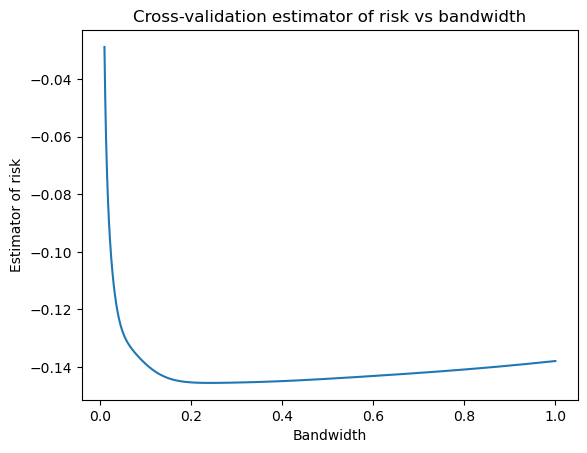

In [44]:
plt.xlabel('Bandwidth')
plt.ylabel('Estimator of risk')
plt.plot(bandwidths[100:], ker_risks[100:])
plt.title('Cross-validation estimator of risk vs bandwidth')

In [45]:
# The bandwidth that gives the lowest value of \hat J
# among the bandwidths that we tested.
best_bandwidth = bandwidths[np.argmin(ker_risks)]

In [46]:
print(f'Best bandwidth: {best_bandwidth:.4f}')

Best bandwidth: 0.2419


In [47]:
def ker_est(bandwidth):
    """The kernel estimator for the specified bandwidth"""
    def f(x):
        arr = K((x - X) / bandwidth)
        return np.sum(arr) / (n * bandwidth)
    
    return f

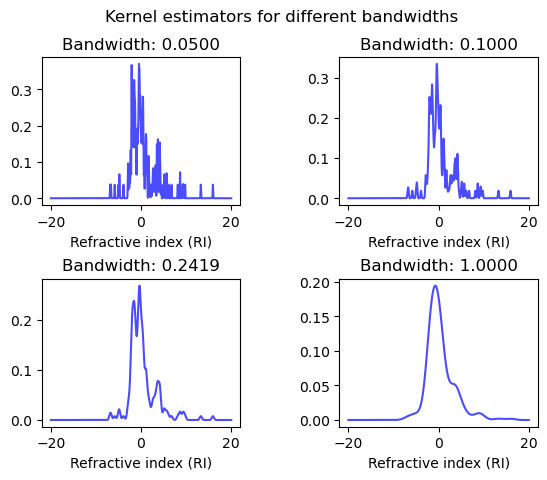

In [48]:
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Kernel estimators for different bandwidths')

x = np.linspace(lower, upper, 10000)
for i,bandwidth in enumerate([0.05, 0.1, best_bandwidth, 1]):
    ax = axs[i // 2][i % 2]
    f = ker_est(bandwidth)
    y = list(map(f, x))
    ax.plot(x, y, c='blue', alpha=0.7)
    ax.set_xlabel('Refractive index (RI)')
    ax.set_title(f'Bandwidth: {bandwidth:.4f}')

Now let's compute an estimated confidence band for the density using equation 20.27.

In [49]:
def s2(x):
    """The function s^2 appearing in equation 20.27"""
    Y = K((x - X) / best_bandwidth) / best_bandwidth
    return np.sum((Y - Y.mean())**2) / (n - 1)

In [50]:
se = lambda x: np.sqrt(s2(x) / n)

In [51]:
omega = 3 * best_bandwidth

In [52]:
m = (upper - lower) / omega

In [53]:
q = norm.ppf((1 + (1 - 0.05)**(1/m))/2)

In [54]:
f_ker = ker_est(best_bandwidth) 

In [55]:
# The function l_n in equation 20.27
l_ker = lambda x: f_ker(x) - q * se(x)

In [56]:
# The function u_n in equation 20.27
u_ker = lambda x: f_ker(x) + q * se(x)

Here is a plot of a 95% confidence band for the density function.

In [57]:
x = np.linspace(lower, upper, 10000)

In [58]:
l_ker_vals = list(map(l_ker, x))

In [59]:
u_ker_vals = list(map(u_ker, x))

Text(0.5, 1.0, '95% confidence band for the density function')

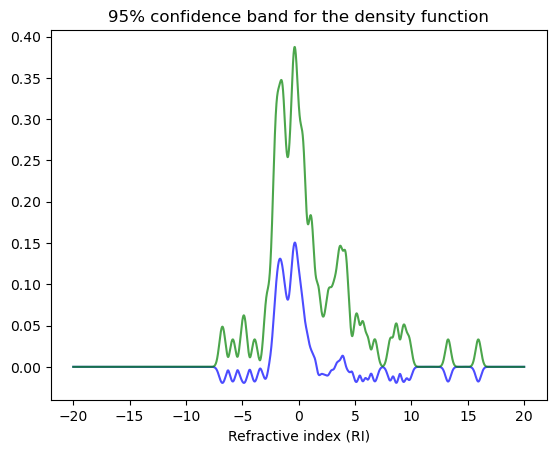

In [60]:
plt.plot(x, l_ker_vals, c='blue', alpha=0.7)
plt.plot(x, u_ker_vals, c='green', alpha=0.7)
plt.xlabel('Refractive index (RI)')
plt.title('95% confidence band for the density function')

The confidence bands for the histogram and the kernel look pretty similar. They both detect two peaks for the density function. It seems we can't be confident in more than two peaks.